In [31]:
import sys
sys.path.append('../')

import numpy as np

from fmodeling.ForwardProcessing1D import forward_with_trace_calcing
from inversion.Strategies.SeismDiffInversion1D import inverse
from inversion.optimizators.optimizations import LBFGSBOptimization, DifferentialEvolution, TrustKrylov, TrustConstr, \
    ConjugateGradient, AxOptimizer
from Tests.test_ForwardProcessing1D import get_model_2layered, get_model_3layered
from Data.geol_models import get_model_3layered_fluid_rp_dicts
from objects.Data.WavePlaceholder import OWT, WaveDataPlaceholder
from objects.Models.Models import SeismicModel1D
from objects.Attributes.RockPhysics.RockPhysicsAttribute import RockPhysicsAttribute
from objects.Attributes.Seismic.SeismicAttribute import SeismicAttribute
from objects.Models.Layer1D import Layer1D, LayerOPT
import time

from matplotlib import pyplot as plt
from inversion.Strategies.SeismDiffInversion1D import func_to_optimize


In [32]:
from Visualization.Seismic import visualize_seismogram
from scipy.optimize import approx_fprime


In [33]:
def plot_1D_err(forward_params, nvals, min_max=None, dot=False, vline_x=None):
    
    if min_max is None:
        min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
        max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
        
    else:
        min_val = np.array([min_max[0]])
        max_val = np.array([min_max[1]])
    
    dval = (max_val - min_val) / nvals

    val_x = [min_val + dval*i for i in range(nvals+1)]
    errs = []
    for val in val_x:
        errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))
        
    plt.plot(val_x, errs)
    if dot:
        plt.plot(val_x, errs, 'o')
        
    if vline_x is not None:
        plt.vlines(vline_x, ymin=min(errs), ymax=max(errs), colors='r')
        
    plt.show()

def optimization_func_2D(forward_params, x, y):
    indexes_1 = np.arange(x.shape[0])
    indexes_2 = np.arange(x.shape[1])
    
    Z = np.zeros((x.shape[0], x.shape[1]))
    
    for ind1 in indexes_1:
        for ind2 in indexes_2:
            Z[ind1, ind2] = func_to_optimize([x[ind1, ind2], y[ind1, ind2]], placeholders, forward_params, helper=None, show_tol=False)
        
    return Z

def plot_2D_err(forward_params, nvals, ncontous=10, points=None):
    min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
    max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
    
    dval = (max_val - min_val) / nvals

    val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
    val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

    X, Y = np.meshgrid(val_1_x, val_2_x)

    Z = optimization_func_2D(forward_params, X, Y)
    
    plt.contourf(X, Y, Z, ncontous, cmap='seismic')
    plt.colorbar()
    
    if points is not None:
        plt.plot(points[0], points[1], marker='o', color='green', markersize=5)

# Четырехслойная модель с газоосадками

In [34]:
h = [
    67.5,
    22.5,
    20
]

In [35]:
layer_1_seism = {
    'vp': 1500,
    'vs': 700,
    'rho': 1000
}

layer_2_rp = {
    "name": "unconsolidated",
    "components": {
                    "Ksi": {
                      "value": 38,
                      "optimize": True,
                      "min": 5,
                      "max": 60
                    },
					"Gsi": {
                      "value": 44,
                      "optimize": True,
                      "min": 30,
                      "max": 50
                    },
					"rhosi": {
                      "value": 2.2,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Ksh": {
                      "value": 21.5,
                      "optimize": True,
                      "min": 10,
                      "max": 30
                    },
					"Gsh": {
                      "value": 7,
                      "optimize": True,
                      "min": 1,
                      "max": 20
                    },
					"rhosh": {
                      "value": 2.43,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kincl": {
                      "value": 36.9,
                      "optimize": False,
                      "min": 35,
                      "max": 40
                    },
                    "Gincl": {
                      "value": 31,
                      "optimize": False,
                      "min": 30,
                      "max": 35
                    },
                    "rhoincl": {
                      "value": 2.2,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kfl": {
                      "value": 2.29,
                      "optimize": False,
                      "min": 0.5,
                      "max": 5
                    },
                    "rhofl": {
                      "value": 1,
                      "optimize": False,
                      "min": 0.5,
                      "max": 1.5
                    },
#                     "Vsi": {
#                       "value": 0.01,
#                       "optimize": False,
#                       "min": 0.5,
#                       "max": 0.99
#                     },
                    "Vsh": {
                      "value": 0.7,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "Vincl": {
                      "value": 0,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "phi": {
                      "value": 0.74,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    }
                  }
}

layer_3_seism = {
    'vp': 2000,
    'vs': 1000,
    'rho': 2070
}

# посмотреть в дипломе Машки!
layer_4_seism = {
    'vp': 6600,
    'vs': 3600,
    'rho': 2600,
}

In [36]:
optimization_list = [
    "Ksi",
#     "Gsi",
#     "rhosi",
    "Ksh",
#     "Gsh",
#     "rhosh",
#     "Kfl",
#     "rhofl",
#     "Vsh",
#     "Vincl",
#     "phi"
]

for key in layer_2_rp['components'].keys():
    if key in optimization_list:
        layer_2_rp['components'][key]["optimize"] = True
        
    else:
        layer_2_rp['components'][key]["optimize"] = False

In [37]:
layer_1 = Layer1D(h[0],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_1_seism),
                  opt=LayerOPT.NO)
layer_2 = Layer1D(h[1],
                  rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
                  seism_attribute=None,
                  opt=LayerOPT.RP)
layer_3 = Layer1D(h[2],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_3_seism),
                  opt=LayerOPT.NO)
layer_4 = Layer1D(-1,
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_4_seism),
                  opt=LayerOPT.NO)

In [38]:
model = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

In [39]:
# Многоканальная коса

In [40]:
dx = 2
nx = 100
x_rec = [i * dx for i in range(1, nx+1)]
wave_types = [OWT.PdPu_water]
dt = 1e-04
tracelen = 2000

# Forward modeling

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu_water-rays...


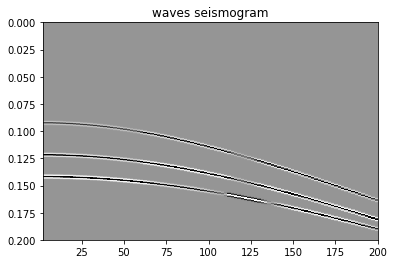

In [41]:
observe, test_seismic = \
    forward_with_trace_calcing(model, x_rec,
                               dt=dt, trace_len=tracelen, wavetypes=wave_types, display_stat=True,
        visualize_res=False, visualize_seismograms=True)

In [42]:
true_vals = model.get_optimization_option('val')

In [43]:
true_vals

OrderedDict([(1, {'Ksi': 38, 'Ksh': 21.5})])

In [44]:
model.layers[0].seism_attribute.vals_dict

{'vp': 1500, 'vs': 700, 'rho': 1000}

In [45]:
model.layers[1].seism_attribute.vals_dict

{'vp': 1534.1089459244965, 'vs': 200.08822703140874, 'rho': 1353.8600000000001}

# Inversion

In [46]:
forward_params = {
    "model": model,
    "x_rec": x_rec,
    "dt": dt,
    "trace_len": tracelen,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

## Create start indexes

In [47]:
def formula(v, h, x):
    return np.sqrt(x**2 + 4*h*h) / v

In [48]:
start_times = formula(1500, 60, np.array(x_rec))
start_indexes = (start_times / dt).astype(int)

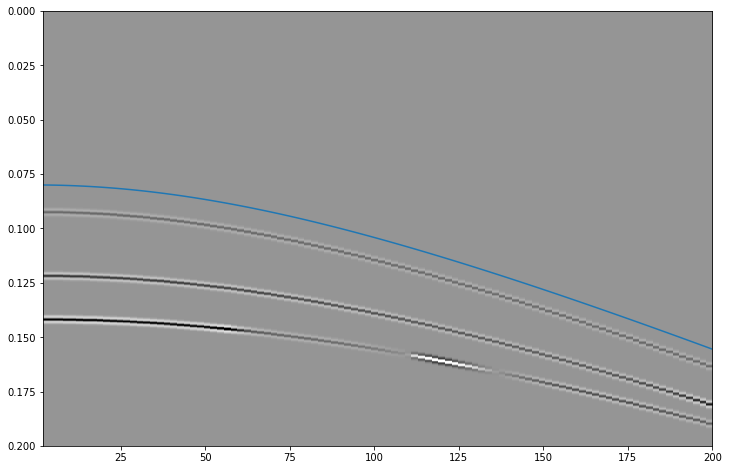

In [49]:
fig, ax = plt.subplots(figsize=(12,8))

visualize_seismogram(fig, ax, test_seismic[OWT.PdPu_water]['seismogram'], wiggles=False)
ax.plot(x_rec, start_times)
plt.show()

In [50]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"],
        start_indexes=start_indexes
    )

## Create optimizers

In [51]:
optimizers_de = [
    DifferentialEvolution(
          popsize= 5,
          maxiter= 50000,
          init= "latinhypercube",
          strategy= "best1bin",
          disp= False,
          polish= False,
          tol= 0.00001,
          mutation= 1.5,
          recombination= 0.6,
          workers= 8
    )
]

In [52]:
optimizers_lbfgs = [
    LBFGSBOptimization(
        maxiter=15000,
        maxfun=15000,
        factr=100,
        maxls=50,
        pgtol=1e-7,
        epsilon=1e-7,
        iprint=1,
        disp=1
    )
]

In [53]:
optimizers_cg = [
    ConjugateGradient(
    )
]

In [54]:
optimizers_ax = [
    AxOptimizer(num_evals=50, log_scale=False)
]

In [55]:
min_vals = forward_params['model'].get_optimization_option('min', vectorize=True)
max_vals = forward_params['model'].get_optimization_option('max', vectorize=True)
start_vals = np.random.uniform(min_vals, max_vals)

print(min_vals, max_vals)

[ 5 10] [60 30]


In [56]:
start_vals

array([ 8.85680646, 26.31964391])

In [57]:
start_vals = [50, 27.5]

In [58]:
forward_params['model'].set_optimization_option(start_vals)

func_to_optimize(forward_params['model'].get_optimization_option('val', vectorize=True), placeholders, forward_params, helper=None, show_tol=False)

inf

## Check sensitivity

In [59]:
def func_(xk):
    return func_to_optimize(xk, placeholders, forward_params, helper=None, show_tol=False)

def func_min_max(xk):
    xk = min_vals + xk * (max_vals - min_vals)
    
    return func_to_optimize(xk, placeholders, forward_params, helper=None, show_tol=False)

nrepeats = 5

grads = []

for i in range(nrepeats):
    start_vals = np.random.uniform(min_vals, max_vals)
    start_vals_minmax = (start_vals - min_vals) / (max_vals - min_vals)
    
#     grads.append(approx_fprime(start_vals, func_, epsilon=[1e-6]*len(start_vals)))
    grads.append(approx_fprime(start_vals_minmax, func_min_max, epsilon=[1e-6]*len(start_vals)))
    
grads

/home/apenkin/.local/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


[array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan])]

In [60]:
model.get_optimization_option('val')

OrderedDict([(1, {'Ksi': 46.12209693198455, 'Ksh': 25.287100339634932})])

# Run inversion process

In [30]:
# scale="minmax"
scale=None
# scale="lg"

start_time = time.time()
inversed_vals = inverse(optimizers_lbfgs, error=1e-7, placeholders=placeholders, forward_params=forward_params, scale=scale)
print(f"time: {time.time() - start_time}")

inf
inf
inf
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
99999
L-BFGS-B stat:
grad: [nan nan]
task: b'ABNORMAL_TERMINATION_IN_LNSRCH'
funcalls: 153
nit

In [62]:
forward_params['model'].set_optimization_option(inversed_vals)
forward_params['model'].scale=None
inversed_vals = forward_params['model'].get_optimization_option('val', vectorize=True)

In [63]:
inversed_vals

array([46.12209693, 25.28710034])

In [64]:
result = {key: {
    "real": val,
    "inversed": inv
} for key, val, inv in zip(true_vals[1].keys(), true_vals[1].values(), inversed_vals)}

In [65]:
result

{'Ksi': {'real': 38, 'inversed': 46.12209693198455},
 'Ksh': {'real': 21.5, 'inversed': 25.287100339634932}}

In [66]:
plot_1D_err(forward_params, 100, vline_x=inversed_model)

NameError: name 'inversed_model' is not defined

In [ ]:
func_to_optimize(inversed_vals, placeholders, forward_params, helper=None, show_tol=False)

In [ ]:
res_observe, res_seismic = forward_with_trace_calcing(forward_params['model'], forward_params['x_rec'], 
                           dt=forward_params['dt'], 
                           trace_len=forward_params['trace_len'], 
                           wavetypes=forward_params['wavetypes'],
            display_stat=True, visualize_res=False,
                               visualize_seismograms=True
            )

In [ ]:
diff = test_seismic[OWT.PdPu_water]['seismogram'] - res_seismic[OWT.PdPu_water]['seismogram']
fig, ax = plt.subplots(figsize=(12,8))

visualize_seismogram(fig, ax, diff, wiggles=False)
plt.show()

In [ ]:
plot_2D_err(forward_params, [7, 7], 20, points=[[inversed_vals[0]], [inversed_vals[1]]])

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
